### Floor plan image ROI masking and template matching (OpenCV)

This notebook lets you:
- Load the provided floor plan image (via path or file upload)
- Draw a polygon to create a mask for an ROI
- Select a smaller template region inside the ROI
- Find and visualize other image areas that match the template (OpenCV template matching)

Notes:
- All visuals are rendered inline with Matplotlib (no GUI windows).
- Works headless; uses `opencv-python-headless`.
- You can rerun the selection cells to refine ROI or template.


In [4]:
!pip install -q --upgrade pip
!pip install -q opencv-python-headless numpy matplotlib scikit-image ipywidgets


In [ ]:
import os
from pathlib import Path
import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib.widgets import PolygonSelector
from matplotlib.path import Path as MplPath
import ipywidgets as widgets
from IPython.display import display

%matplotlib inline

# Helper to display images in RGB
def show(img, title=None, figsize=(10, 8)):
    if img is None:
        print("None image")
        return
    if img.ndim == 2:
        rgb = img
        cmap = 'gray'
    else:
        rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        cmap = None
    plt.figure(figsize=figsize)
    plt.imshow(rgb, cmap=cmap)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

# Configure a default image path if present in repo
DEFAULT_IMAGE_PATHS = [
    "/workspace/floor-plan-object-detection/floorplan.png",
    "/workspace/floor-plan-object-detection/floorplan.jpg",
    "/workspace/floor-plan-object-detection/floorplan.jpeg",
]

def find_default_image():
    for p in DEFAULT_IMAGE_PATHS:
        if os.path.exists(p):
            return p
    return None

image_path_text = widgets.Text(
    value=find_default_image() or "",
    placeholder='Absolute path to image (e.g. /workspace/.../plan.png)',
    description='Image path:',
    layout=widgets.Layout(width='90%')
)
file_upload = widgets.FileUpload(accept='image/*', multiple=False, description='Upload image')

out = widgets.Output()

@out.capture(clear_output=True)
def on_change(_):
    img = None
    path = image_path_text.value.strip()
    if path and os.path.exists(path):
        img = cv2.imdecode(np.fromfile(path, dtype=np.uint8), cv2.IMREAD_COLOR)
        # Fallback if fromfile not needed
        if img is None:
            img = cv2.imread(path, cv2.IMREAD_COLOR)
    elif file_upload.value:
        # Read from uploaded
        up = next(iter(file_upload.value.values()))
        img_bytes = up['content']
        img = cv2.imdecode(np.frombuffer(img_bytes, np.uint8), cv2.IMREAD_COLOR)
    if img is None:
        print("Provide a valid image path or upload an image.")
        return
    show(img, title='Loaded image')

controls = widgets.VBox([
    image_path_text,
    file_upload,
])

image_path_text.observe(on_change, names='value')
file_upload.observe(on_change, names='value')

display(controls, out)

# Prime first render if a default path exists
on_change(None)


Output()

RuntimeError: No image loaded. Provide a path or upload above.

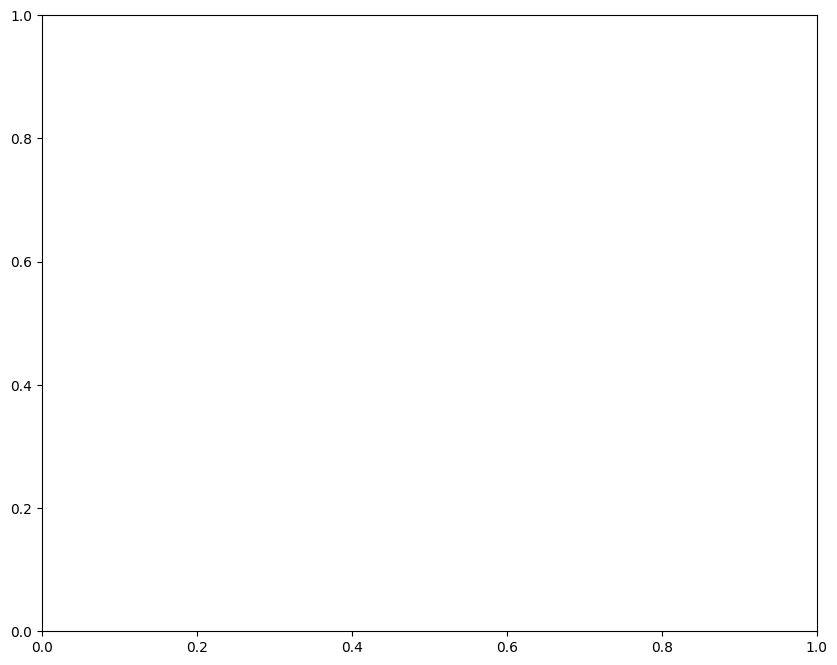

In [ ]:
# Draw polygon to create ROI mask
# Click to add vertices, press 'enter' to finalize or 'esc' to cancel.

_loaded_image_cache = {'img': None}

def _get_current_image():
    # Prefer path text, else last uploaded
    path = image_path_text.value.strip()
    if path and os.path.exists(path):
        img = cv2.imdecode(np.fromfile(path, dtype=np.uint8), cv2.IMREAD_COLOR)
        if img is None:
            img = cv2.imread(path, cv2.IMREAD_COLOR)
        return img
    if file_upload.value:
        up = next(iter(file_upload.value.values()))
        return cv2.imdecode(np.frombuffer(up['content'], np.uint8), cv2.IMREAD_COLOR)
    return None

roi_mask = None
roi_polygon = []

fig, ax = plt.subplots(figsize=(10, 8))
img = _get_current_image()
if img is None:
    raise RuntimeError("No image loaded. Provide a path or upload above.")
ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax.set_title('Draw polygon ROI and press Enter')
ax.axis('off')

poly_selector_done = widgets.Output()

pts_result = {'verts': None}

def onselect(verts):
    pts_result['verts'] = np.array(verts, dtype=np.float32)

selector = PolygonSelector(ax, onselect, useblit=True, props=dict(color='lime', linewidth=2, alpha=0.8))

@poly_selector_done.capture(clear_output=True)
def finalize(event):
    global roi_mask, roi_polygon
    if event.key == 'enter' and pts_result['verts'] is not None:
        roi_polygon = pts_result['verts']
        mask = np.zeros(img.shape[:2], dtype=np.uint8)
        cv2.fillPoly(mask, [roi_polygon.astype(np.int32)], 255)
        roi_mask = mask
        plt.close(fig)
        show(cv2.bitwise_and(img, img, mask=roi_mask), title='ROI extracted via polygon mask')

fig.canvas.mpl_connect('key_press_event', finalize)
plt.show()

display(poly_selector_done)

# roi_mask and roi_polygon are now set after pressing Enter


In [ ]:
# Select a rectangular template region inside the ROI
# Click two corners (top-left then bottom-right) within the ROI image.

if img is None:
    img = _get_current_image()
assert roi_mask is not None, "Run the polygon ROI cell first and press Enter."

roi_img = cv2.bitwise_and(img, img, mask=roi_mask)

fig2, ax2 = plt.subplots(figsize=(10, 8))
ax2.imshow(cv2.cvtColor(roi_img, cv2.COLOR_BGR2RGB))
ax2.set_title('Click two corners for template (TL then BR)')
ax2.axis('off')

clicks = []

rect_out = widgets.Output()

@rect_out.capture(clear_output=True)
def on_click(event):
    if event.inaxes != ax2:
        return
    clicks.append((int(event.xdata), int(event.ydata)))
    if len(clicks) == 2:
        (x1, y1), (x2, y2) = clicks
        x1, x2 = sorted([x1, x2])
        y1, y2 = sorted([y1, y2])
        template = roi_img[y1:y2, x1:x2]
        plt.close(fig2)
        show(template, title=f'Template {template.shape[1]}x{template.shape[0]}')
        globals()['template'] = template

fig2.canvas.mpl_connect('button_press_event', on_click)
plt.show()

display(rect_out)

# The selected template is available as variable `template`


In [ ]:
# Match the template against the full image using OpenCV template matching
# We also provide a feature-based ORB matching preview for robustness.

assert 'template' in globals(), "Select a template first."
full_img = _get_current_image()

# Basic normalized cross-correlation template matching
method = cv2.TM_CCOEFF_NORMED
res = cv2.matchTemplate(cv2.cvtColor(full_img, cv2.COLOR_BGR2GRAY), 
                        cv2.cvtColor(template, cv2.COLOR_BGR2GRAY), method)

threshold_slider = widgets.FloatSlider(value=0.7, min=0.4, max=0.99, step=0.01, description='Thresh:')
max_count_slider = widgets.IntSlider(value=20, min=1, max=200, step=1, description='Max boxes:')

@widgets.interact(threshold=threshold_slider, max_count=max_count_slider)
def _find_matches(threshold, max_count):
    matches_img = full_img.copy()
    t_h, t_w = template.shape[:2]
    loc = np.where(res >= threshold)
    points = list(zip(*loc[::-1]))
    # Non-maximum suppression: skip close duplicates
    picked = []
    for pt in points:
        if all(abs(pt[0]-q[0]) > t_w//2 or abs(pt[1]-q[1]) > t_h//2 for q in picked):
            picked.append(pt)
        if len(picked) >= max_count:
            break
    for pt in picked:
        cv2.rectangle(matches_img, pt, (pt[0]+t_w, pt[1]+t_h), (0, 255, 0), 2)
    show(matches_img, title=f'Template matches (n={len(picked)})')

# Optional: feature-based ORB visualization
try:
    orb = cv2.ORB_create(nfeatures=2000)
    kp1, des1 = orb.detectAndCompute(cv2.cvtColor(template, cv2.COLOR_BGR2GRAY), None)
    kp2, des2 = orb.detectAndCompute(cv2.cvtColor(full_img, cv2.COLOR_BGR2GRAY), None)
    if des1 is not None and des2 is not None:
        bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
        matches = bf.match(des1, des2)
        matches = sorted(matches, key=lambda m: m.distance)[:50]
        vis = cv2.drawMatches(template, kp1, full_img, kp2, matches, None,
                               flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
        show(vis, title='ORB feature matches (preview)')
except Exception as e:
    print('ORB matching preview skipped:', e)


### Notes on approach and references

- Mask from polygon: create a binary mask and fill with `cv2.fillPoly`, then `bitwise_and` to extract ROI. See OpenCV mask usage and various examples.
- Template matching: `cv2.matchTemplate` is simple but sensitive to scale/rotation/illumination changes; use normalized methods like `TM_CCOEFF_NORMED`. For varying scales/rotations, prefer feature methods (ORB/SIFT) and/or multiscale search.
- Feature matching: ORB is fast and robust to rotation/scale to a degree; SIFT provides high-quality features (requires `opencv-contrib-python`). You can swap ORB for SIFT easily.

References:
- OpenCV template matching tutorial: docs.opencv.org/4.x/d4/dc6/tutorial_py_template_matching.html
- Polygon to mask with `cv2.fillPoly`: stackoverflow.com/q/30901019
- Feature matching overview (ORB, BFMatcher): geeksforgeeks.org/feature-matching-in-opencv/
